In [1]:
from sys import path
path.append('../src/')

import os
import mlflow
import mlflow.keras
import numpy as np
import pickle as pkl
import random as rn
import tensorflow as tf
import matplotlib.pyplot as plt
from os.path import join
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import BinaryCrossentropy
from keras.models import load_model, Model
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import compute_class_weight
from skmultilearn.model_selection import iterative_train_test_split

from global_config import FILE_DUMP_IMAGES, FILE_DUMP_MRKS
from global_config import RANDOM_SEED, IMAGE_SIZE
from custom_metrics import matthews_correlation_coefficient as mcc
from utils import plot, load

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
TEST_SIZE = 0.2

MLFLOW_EXPERIMENT_NAME = 'Fine-tuning'

In [3]:
PATH_TO_ROOT = '..'

FOLDER_MODELS = join(PATH_TO_ROOT, 'models/unsupervised_supervised/')
FILE_BASE_MODEL = join(FOLDER_MODELS, 'model_2020_07_12-02_22_54.h5')
FILE_DUMP_IMAGES = join(PATH_TO_ROOT, FILE_DUMP_IMAGES)
FILE_DUMP_MRKS = join(PATH_TO_ROOT, FILE_DUMP_MRKS)

print(FOLDER_MODELS)
print(FILE_BASE_MODEL)
print(FILE_DUMP_IMAGES)
print(FILE_DUMP_MRKS)

..\models/unsupervised_supervised/
..\models/unsupervised_supervised/model_2020_07_12-02_22_54.h5
..\data/cropped_faces/cropped_faces_images.pkl
..\data/cropped_faces/cropped_faces_mrks.pkl


In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'

def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)
    
def compute_class_weights(y):
    classes = np.unique(y)
    weights = compute_class_weight('balanced', classes, y)
    class_weights = dict(zip(classes, weights))
    return class_weights

def get_output_counts(output_names, y):
    output_counts = [np.unique(y[:, i], return_counts=True) for i in range(y.shape[1])]
    output_prop = [(unique, counts / counts.sum()) for unique, counts in output_counts]

    dict_counts = {name: dict(zip(unique, counts)) for name, (unique, counts) in zip(output_names, output_counts)}
    dict_props = {name: dict(zip(unique, counts)) for name, (unique, counts) in zip(output_names, output_prop)}
    return dict_counts, dict_props

# Load Data

In [5]:
x, _ = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
mrks, _ = pkl.load(open(FILE_DUMP_MRKS, 'rb'))

y = np.array([mrk.photo_reqs.values() for mrk in mrks])

print(x.shape, x.dtype)
print(mrks.shape, mrks.dtype)
print(y.shape, y.dtype)

(5731, 160, 160, 3) float32
(5731,) object
(5731, 23) int32


# Load Model

In [6]:
model = load_model(FILE_BASE_MODEL)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Model: "ICAOnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 160, 160, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 160, 160, 32)      896       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 160, 160, 32)      128       
_________________________________________________________________
relu_1 (Activation)          (None, 160, 160, 32)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 80, 80, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 80, 80, 64)        18496     
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 80, 80, 64)        256 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


# Fine-tuning 

In [7]:
np.random.seed(RANDOM_SEED)
x_train_idx, y_train, x_val_idx, y_val = iterative_train_test_split(np.arange(x.shape[0]).reshape(-1, 1), y, test_size=TEST_SIZE)
x_train_idx = x_train_idx.ravel()
x_val_idx = x_val_idx.ravel()

x_train = x[x_train_idx] / 255
x_val = x[x_val_idx] / 255

print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_val.shape, x_val.dtype)
print(y_val.shape, y_val.dtype)

(4573, 160, 160, 3) float32
(4573, 23) int32
(1158, 160, 160, 3) float32
(1158, 23) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4573 samples, validate on 1158 samples
Epoch 1/100
4573/4573 [==============================] - 22s 5ms/step - loss: 0.5325 - accuracy: 0.9106 - matthews_correlation_coefficient: 0.7145 - val_loss: 0.4477 - val_accuracy: 0.9226 - val_matthews_correlation_coefficient: 0.7287

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.72870, saving model to ..\models/unsupervised_supervised/fine_tuning_2020_08_09-23_35_19.h5
Epoch 2/100
4573/4573 [==============================] - 18s 4ms/step - loss: 0.4646 - accuracy: 0.9076 - matthews_correlation_coefficient: 0.6980 - val_loss: 0.4377 - val_accuracy: 0.9325 - val_matthews_correlation_coefficient: 0.7636

Epoch 00002: val_matthews_correlation_coefficient improved from 0.72870 to 0.76361, saving model to ..\models/unsupervised_supervised/fine_tuning_2020_08_09-23_35_19.h5
Epoch 3/100
4573/4573 [==============================] - 18s 4ms/step - loss: 0.4551 - accuracy: 0.9119 - matthews_correlation_coefficient: 0.7

4573/4573 [==============================] - 18s 4ms/step - loss: 0.4181 - accuracy: 0.9320 - matthews_correlation_coefficient: 0.7802 - val_loss: 0.4004 - val_accuracy: 0.9433 - val_matthews_correlation_coefficient: 0.7975

Epoch 00023: val_matthews_correlation_coefficient did not improve from 0.80977
Epoch 24/100
4573/4573 [==============================] - 18s 4ms/step - loss: 0.4175 - accuracy: 0.9320 - matthews_correlation_coefficient: 0.7803 - val_loss: 0.3985 - val_accuracy: 0.9450 - val_matthews_correlation_coefficient: 0.8052

Epoch 00024: val_matthews_correlation_coefficient did not improve from 0.80977
Epoch 25/100
4573/4573 [==============================] - 18s 4ms/step - loss: 0.4165 - accuracy: 0.9334 - matthews_correlation_coefficient: 0.7852 - val_loss: 0.3987 - val_accuracy: 0.9469 - val_matthews_correlation_coefficient: 0.8121

Epoch 00025: val_matthews_correlation_coefficient improved from 0.80977 to 0.81212, saving model to ..\models/unsupervised_supervised/fine_tu

4573/4573 [==============================] - 18s 4ms/step - loss: 0.4071 - accuracy: 0.9395 - matthews_correlation_coefficient: 0.8060 - val_loss: 0.3940 - val_accuracy: 0.9479 - val_matthews_correlation_coefficient: 0.8161

Epoch 00048: val_matthews_correlation_coefficient did not improve from 0.81783
Epoch 49/100
4573/4573 [==============================] - 18s 4ms/step - loss: 0.4067 - accuracy: 0.9396 - matthews_correlation_coefficient: 0.8066 - val_loss: 0.3946 - val_accuracy: 0.9474 - val_matthews_correlation_coefficient: 0.8143

Epoch 00049: val_matthews_correlation_coefficient did not improve from 0.81783
Epoch 50/100
4573/4573 [==============================] - 18s 4ms/step - loss: 0.4078 - accuracy: 0.9385 - matthews_correlation_coefficient: 0.8023 - val_loss: 0.3958 - val_accuracy: 0.9444 - val_matthews_correlation_coefficient: 0.8046

Epoch 00050: val_matthews_correlation_coefficient did not improve from 0.81783
Epoch 51/100
4573/4573 [==============================] - 18s 

4573/4573 [==============================] - 18s 4ms/step - loss: 0.4022 - accuracy: 0.9427 - matthews_correlation_coefficient: 0.8171 - val_loss: 0.3936 - val_accuracy: 0.9472 - val_matthews_correlation_coefficient: 0.8137

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.82190
Epoch 74/100
4573/4573 [==============================] - 18s 4ms/step - loss: 0.4019 - accuracy: 0.9434 - matthews_correlation_coefficient: 0.8190 - val_loss: 0.3943 - val_accuracy: 0.9487 - val_matthews_correlation_coefficient: 0.8187

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.82190
Epoch 75/100
4573/4573 [==============================] - 18s 4ms/step - loss: 0.4020 - accuracy: 0.9428 - matthews_correlation_coefficient: 0.8171 - val_loss: 0.3958 - val_accuracy: 0.9463 - val_matthews_correlation_coefficient: 0.8111

Epoch 00075: val_matthews_correlation_coefficient did not improve from 0.82190
Epoch 76/100
4573/4573 [==============================] - 18s 

4573/4573 [==============================] - 18s 4ms/step - loss: 0.3970 - accuracy: 0.9477 - matthews_correlation_coefficient: 0.8331 - val_loss: 0.3937 - val_accuracy: 0.9474 - val_matthews_correlation_coefficient: 0.8170

Epoch 00099: val_matthews_correlation_coefficient did not improve from 0.82190
Epoch 100/100
4573/4573 [==============================] - 18s 4ms/step - loss: 0.3984 - accuracy: 0.9459 - matthews_correlation_coefficient: 0.8275 - val_loss: 0.3946 - val_accuracy: 0.9473 - val_matthews_correlation_coefficient: 0.8161

Epoch 00100: val_matthews_correlation_coefficient did not improve from 0.82190


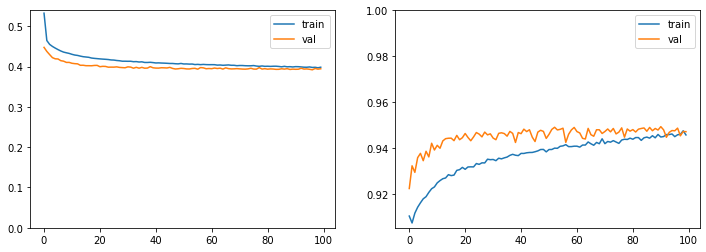

In [8]:
set_random_seeds()
LABEL_SMOOTHING = 0.2

model.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss=BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING), 
    metrics=['accuracy', mcc]
)

metric_to_monitor = 'val_matthews_correlation_coefficient'
FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix='fine_tuning_')

list_callbacks = [
    EarlyStopping(monitor=metric_to_monitor, mode='max', patience=50, verbose=1, restore_best_weights=True),
    ModelCheckpoint(FILE_MODEL, monitor=metric_to_monitor, mode='max', verbose=1, save_best_only=True)
]

class_weights = [compute_class_weights(y_train[:, i]) for i in range(y_train.shape[1])]

mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
mlflow.log_param("seed", RANDOM_SEED)
mlflow.log_param("label_smoothing", LABEL_SMOOTHING)
mlflow.keras.autolog()

hist = model.fit(
    x=x_train, 
    y=y_train, 
    batch_size=32, 
    epochs=100, 
    validation_data=(x_val, y_val),
    callbacks=list_callbacks,
    verbose=1,
    class_weight=class_weights,
)
plot.keras_hist(hist.history)

mlflow.end_run()

# Test 

In [45]:
import cv2

list_files = ['../data/cropped_faces/images/AR_FDB_m-013-17.png']

im = load.images_from_list_files(list_files, output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

1 of 1


In [50]:
custom_objects = {
    'matthews_correlation_coefficient': mcc,
}

set_random_seeds()

model_recompiled = load_model(FILE_MODEL, custom_objects=custom_objects)
model_recompiled.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING),
)
model_recompiled.save(FILE_MODEL)

y_pred_1 = model.predict(x_val)
y_pred_2 = model_recompiled.predict(x_val)

assert(np.allclose(y_pred_1, y_pred_2))

AssertionError: 

In [52]:
merged_model = load_model(FILE_MODEL)
y_pred = merged_model.predict(im)
for pred in y_pred[0]:
    print(pred)

0.9474306
0.21310046
0.8815039
0.89919424
0.86604834
0.92013633
0.81341183
0.5029172
0.2309705
0.40485346
0.85561407
0.9681579
0.23202652
0.8586847
0.88999206
0.730492
0.6731998
0.92121184
0.56586283
0.8948059
0.7712209
0.07655636
0.9016894
